# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4571136/11490434 [==========>...................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 11:40 - loss: 0.6944

  32/1875 [..............................] - ETA: 3s - loss: 0.5391   

  67/1875 [>.............................] - ETA: 2s - loss: 0.4529

 103/1875 [>.............................] - ETA: 2s - loss: 0.4092

 141/1875 [=>............................] - ETA: 2s - loss: 0.3807

 178/1875 [=>............................] - ETA: 2s - loss: 0.3611

 209/1875 [==>...........................] - ETA: 2s - loss: 0.3481

 242/1875 [==>...........................] - ETA: 2s - loss: 0.3366

 276/1875 [===>..........................] - ETA: 2s - loss: 0.3265

 315/1875 [====>.........................] - ETA: 2s - loss: 0.3166

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3076

 398/1875 [=====>........................] - ETA: 2s - loss: 0.2995

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2933

 474/1875 [======>.......................] - ETA: 1s - loss: 0.2871

 513/1875 [=======>......................] - ETA: 1s - loss: 0.2816

 555/1875 [=======>......................] - ETA: 1s - loss: 0.2763

 594/1875 [========>.....................] - ETA: 1s - loss: 0.2717

 630/1875 [=========>....................] - ETA: 1s - loss: 0.2678

 667/1875 [=========>....................] - ETA: 1s - loss: 0.2640

 705/1875 [==========>...................] - ETA: 1s - loss: 0.2604

 741/1875 [==========>...................] - ETA: 1s - loss: 0.2571

 777/1875 [===========>..................] - ETA: 1s - loss: 0.2541

 805/1875 [===========>..................] - ETA: 1s - loss: 0.2518

 831/1875 [============>.................] - ETA: 1s - loss: 0.2498

 861/1875 [============>.................] - ETA: 1s - loss: 0.2476

 893/1875 [=============>................] - ETA: 1s - loss: 0.2453

 923/1875 [=============>................] - ETA: 1s - loss: 0.2433

 946/1875 [==============>...............] - ETA: 1s - loss: 0.2417

 973/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1002/1875 [===============>..............] - ETA: 1s - loss: 0.2382

1030/1875 [===============>..............] - ETA: 1s - loss: 0.2365

1058/1875 [===============>..............] - ETA: 1s - loss: 0.2349

1086/1875 [================>.............] - ETA: 1s - loss: 0.2333

1119/1875 [================>.............] - ETA: 1s - loss: 0.2315

1154/1875 [=================>............] - ETA: 1s - loss: 0.2297

1188/1875 [==================>...........] - ETA: 1s - loss: 0.2280

1222/1875 [==================>...........] - ETA: 0s - loss: 0.2263

1255/1875 [===================>..........] - ETA: 0s - loss: 0.2248

1288/1875 [===================>..........] - ETA: 0s - loss: 0.2233

1321/1875 [====================>.........] - ETA: 0s - loss: 0.2218

1354/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1387/1875 [=====================>........] - ETA: 0s - loss: 0.2190

1420/1875 [=====================>........] - ETA: 0s - loss: 0.2177

1448/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1477/1875 [======================>.......] - ETA: 0s - loss: 0.2154

1505/1875 [=======================>......] - ETA: 0s - loss: 0.2144

1536/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2121

1602/1875 [========================>.....] - ETA: 0s - loss: 0.2109

1634/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1667/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1699/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1733/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1764/1875 [===========================>..] - ETA: 0s - loss: 0.2057

1797/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1828/1875 [============================>.] - ETA: 0s - loss: 0.2038

1863/1875 [============================>.] - ETA: 0s - loss: 0.2028

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1005

  34/1875 [..............................] - ETA: 2s - loss: 0.1107

  66/1875 [>.............................] - ETA: 2s - loss: 0.1107

  98/1875 [>.............................] - ETA: 2s - loss: 0.1105

 132/1875 [=>............................] - ETA: 2s - loss: 0.1103

 164/1875 [=>............................] - ETA: 2s - loss: 0.1102

 196/1875 [==>...........................] - ETA: 2s - loss: 0.1101

 227/1875 [==>...........................] - ETA: 2s - loss: 0.1099

 258/1875 [===>..........................] - ETA: 2s - loss: 0.1098

 293/1875 [===>..........................] - ETA: 2s - loss: 0.1096

 325/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 356/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 387/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 415/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 438/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 469/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 502/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 534/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 593/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 618/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 653/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 683/1875 [=========>....................] - ETA: 1s - loss: 0.1082

 717/1875 [==========>...................] - ETA: 1s - loss: 0.1081

 749/1875 [==========>...................] - ETA: 1s - loss: 0.1080

 779/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 806/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 839/1875 [============>.................] - ETA: 1s - loss: 0.1078

 869/1875 [============>.................] - ETA: 1s - loss: 0.1077

 903/1875 [=============>................] - ETA: 1s - loss: 0.1076

 939/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 974/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1043/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1078/1875 [================>.............] - ETA: 1s - loss: 0.1072

1112/1875 [================>.............] - ETA: 1s - loss: 0.1072

1147/1875 [=================>............] - ETA: 1s - loss: 0.1071

1183/1875 [=================>............] - ETA: 1s - loss: 0.1070

1207/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1243/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1277/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1309/1875 [===================>..........] - ETA: 0s - loss: 0.1068

1338/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1368/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1401/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1434/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1468/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1500/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1533/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1565/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1600/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1625/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1655/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1687/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1715/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1746/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1775/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1805/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1836/1875 [============================>.] - ETA: 0s - loss: 0.1058

1870/1875 [============================>.] - ETA: 0s - loss: 0.1058

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1071

  32/1875 [..............................] - ETA: 3s - loss: 0.0991

  65/1875 [>.............................] - ETA: 2s - loss: 0.0990

  99/1875 [>.............................] - ETA: 2s - loss: 0.0988

 126/1875 [=>............................] - ETA: 2s - loss: 0.0987

 157/1875 [=>............................] - ETA: 2s - loss: 0.0986

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 214/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0983

 273/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 302/1875 [===>..........................] - ETA: 2s - loss: 0.0982

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 394/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0982

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 528/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0981

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0981

 665/1875 [=========>....................] - ETA: 1s - loss: 0.0981

 700/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 734/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 801/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 834/1875 [============>.................] - ETA: 1s - loss: 0.0980

 868/1875 [============>.................] - ETA: 1s - loss: 0.0980

 902/1875 [=============>................] - ETA: 1s - loss: 0.0980

 928/1875 [=============>................] - ETA: 1s - loss: 0.0980

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1015/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1072/1875 [================>.............] - ETA: 1s - loss: 0.0980

1099/1875 [================>.............] - ETA: 1s - loss: 0.0980

1128/1875 [=================>............] - ETA: 1s - loss: 0.0980

1163/1875 [=================>............] - ETA: 1s - loss: 0.0980

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0979

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1334/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1607/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1668/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1831/1875 [============================>.] - ETA: 0s - loss: 0.0978

1859/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0990

  31/1875 [..............................] - ETA: 3s - loss: 0.0959

  59/1875 [..............................] - ETA: 3s - loss: 0.0954

  85/1875 [>.............................] - ETA: 3s - loss: 0.0952

 113/1875 [>.............................] - ETA: 3s - loss: 0.0952

 142/1875 [=>............................] - ETA: 3s - loss: 0.0952

 170/1875 [=>............................] - ETA: 3s - loss: 0.0953

 196/1875 [==>...........................] - ETA: 3s - loss: 0.0953

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 253/1875 [===>..........................] - ETA: 3s - loss: 0.0954

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 359/1875 [====>.........................] - ETA: 2s - loss: 0.0955

 395/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0956

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0956

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 609/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 645/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 682/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 718/1875 [==========>...................] - ETA: 1s - loss: 0.0957

 755/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0957

 819/1875 [============>.................] - ETA: 1s - loss: 0.0957

 855/1875 [============>.................] - ETA: 1s - loss: 0.0958

 891/1875 [=============>................] - ETA: 1s - loss: 0.0958

 926/1875 [=============>................] - ETA: 1s - loss: 0.0958

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1033/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1069/1875 [================>.............] - ETA: 1s - loss: 0.0958

1106/1875 [================>.............] - ETA: 1s - loss: 0.0958

1140/1875 [=================>............] - ETA: 1s - loss: 0.0958

1174/1875 [=================>............] - ETA: 1s - loss: 0.0958

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1244/1875 [==================>...........] - ETA: 0s - loss: 0.0958

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1313/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1351/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1494/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1825/1875 [============================>.] - ETA: 0s - loss: 0.0958

1858/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0841

  35/1875 [..............................] - ETA: 2s - loss: 0.0946

  65/1875 [>.............................] - ETA: 2s - loss: 0.0950

  90/1875 [>.............................] - ETA: 3s - loss: 0.0952

 117/1875 [>.............................] - ETA: 3s - loss: 0.0951

 152/1875 [=>............................] - ETA: 2s - loss: 0.0950

 187/1875 [=>............................] - ETA: 2s - loss: 0.0950

 224/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 261/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 296/1875 [===>..........................] - ETA: 2s - loss: 0.0950

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 370/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0950

 480/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 553/1875 [=======>......................] - ETA: 1s - loss: 0.0951

 588/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 623/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 658/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 692/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 726/1875 [==========>...................] - ETA: 1s - loss: 0.0951

 758/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0951

 827/1875 [============>.................] - ETA: 1s - loss: 0.0951

 863/1875 [============>.................] - ETA: 1s - loss: 0.0952

 890/1875 [=============>................] - ETA: 1s - loss: 0.0952

 919/1875 [=============>................] - ETA: 1s - loss: 0.0952

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1040/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1066/1875 [================>.............] - ETA: 1s - loss: 0.0952

1099/1875 [================>.............] - ETA: 1s - loss: 0.0952

1128/1875 [=================>............] - ETA: 1s - loss: 0.0952

1159/1875 [=================>............] - ETA: 1s - loss: 0.0952

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1256/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1292/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1325/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1420/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1657/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1828/1875 [============================>.] - ETA: 0s - loss: 0.0952

1861/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

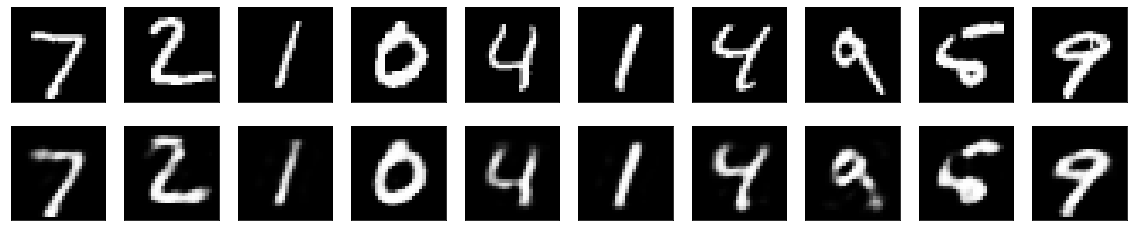

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
